# SNN-MLP-Multivariate-Sigma-Delta-Network-SDNN-LAVA

In [10]:
import sys, os
import numpy as np
from matplotlib import pyplot
import h5py
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import lava.lib.dl.slayer as slayer
#import utils
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import lava
import pandas as pd
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from pandas import to_datetime

# MLP  SD  Multivarite

In [2]:
from pandas import read_csv
#dataset = read_csv('jordan_pv.csv', parse_dates=['date'], index_col='date')
dataset = read_csv('Palestine-PV.csv', parse_dates=['date'],  index_col='date')

# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)

# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
dataset = dataset.sort_index()
# summarize first 5 rows
#print(dataset.head(5))
dataset = dataset[~np.isnan(dataset)]
# Drop rows with missing values
dataset= dataset.dropna()
dataset.info() 
dataset = dataset.astype(np.float64)
#dataset.shape
def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()

    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]

    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names

    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg
# load dataset

values = dataset.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
# frame as supervised learnin
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)',3, 1)
#print(reframed.head())
# Spilt into Train  and Test Set
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X) ,print(train_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)
# Hyperparameters
spike_rate = 0.1
temporal_rate = 1
def event_rate_loss(x, max_rate=0.01):
    mean_event_rate = torch.mean(torch.abs(x))
    return F.mse_loss(F.relu(mean_event_rate - max_rate), torch.zeros_like(mean_event_rate))

# SD MLP

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
train_X = train_X.reshape((train_X.shape[0],   train_X.shape[1],1))
test_X = test_X.reshape((test_X.shape[0],    test_X.shape[1],1))

# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()

        sdnn_params = { # sigma-delta neuron parameters
                'threshold'     : 0.05,    # delta unit threshold
                'tau_grad'      : 0.05,    # delta unit surrogate gradient relaxation parameter
                 'scale_grad'    : 1,      # delta unit surrogate gradient scale parameter
                'requires_grad' : True,   # trainable threshold
                'shared_param'  : True,   # layer wise threshold
                'activation'    : F.relu, # activation function
            }
        sdnn_cnn_params = { # conv layer has additional mean only batch norm
                **sdnn_params,                                 # copy all sdnn_params
                'norm' : slayer.neuron.norm.MeanOnlyBatchNorm, # mean only quantized batch normalizaton
            }
        sdnn_dense_params = { # dense layers have additional dropout units enabled
                **sdnn_cnn_params,                        # copy all sdnn_cnn_params
                'dropout' : slayer.neuron.Dropout(p=0.05), # neuron dropout
            }
        self.blocks = torch.nn.ModuleList([
            # delta encoding of the input
            slayer.block.sigma_delta.Input(sdnn_params),
            slayer.block.sigma_delta.Dense(sdnn_dense_params,18,32, weight_scale=2), #weight_norm=True),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32,32, weight_scale=2),# weight_norm=True),
            
            # linear readout with sigma decoding of output
            slayer.block.sigma_delta.Output(sdnn_cnn_params, 32, 1, weight_scale=2),# weight_norm=True)
        ])

    def forward(self, x):
        count = []
        event_cost = 0
        sparsity_list = []  # Initialize the sparsity list here

        for i, block in enumerate(self.blocks):
            # forward computation is as simple as calling the blocks in a loop
            x = block(x)
            #print("Input shape:", x.shape)
            if hasattr(block, 'neuron'):
                event_cost += event_rate_loss(x)
                masked_x = torch.where(x > 0, x, torch.zeros_like(x))
                # Compute the sum of absolute values of this new tensor
                count.append(torch.sum(torch.abs(masked_x)).item())
                #count.append(torch.sum(torch.sum((x[..., 1:]) > 0).to(x.dtype)).item())
        return x, event_cost, torch.FloatTensor(count).reshape((1, -1)).to(x.device)
    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()
        return grad
    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))
train_X = train_X.reshape((train_X.shape[0],train_X.shape[1], 1,1,1))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1], 1,1 ,1))
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)
batch  =64# batch size
lr     = 0.001# leaerning rate
lam    = 0.01  # lagrangian for event rate loss
epochs =60  # training epochs
steps  = [60, 120, 160] # learning rate reduction milestones
trained_folder = 'Trained'
logs_folder = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder   , exist_ok=True)
#device = torch.device('cuda')
device = torch.device('cpu')
# Instantiate Network, Optimizer, Dataset, and Dataloader
net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=1e-5) #CONV and Dense
#optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=1e-5) #CONV and Dense
#optimizer = torch.optim.Adam(net.parameters(), lr=0.001)     #For cuba
training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = torch.utils.data.DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testing_set, batch_size=batch, shuffle=False)
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(
    net=net,
    error=lambda output  , target: F.mse_loss(output.flatten(), target.flatten()),
    optimizer=optimizer,
    stats=stats,
    count_log=True,
    lam=lam,
    #classifier=slayer.classifier.Rate.predict
)
for epoch in range(epochs):
   # if epoch in steps:
        #for param_group in optimizer.param_groups:    
          #  print('\nLearning rate reduction from', param_group['lr'])
          #  param_group['lr'] /= 10/3
        
    for i, (input, ground_truth) in enumerate(train_loader): # training loop
        
        assistant.train(input, ground_truth)
        print(f'\r[Epoch {epoch:3d}/{epochs}] {stats}', end='')
    
    for i, (input, ground_truth) in enumerate(test_loader): # testing loop
        
        assistant.test(input, ground_truth)
        print(f'\r[Epoch {epoch:3d}/{epochs}] {stats}', end='')
        
    if epoch%50==49: print() 
    if stats.testing.min_loss:  
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    
    # checkpoint saves
    if epoch%10 == 0:
        torch.save({'net': net.state_dict(), 'optimizer': optimizer.state_dict()}, logs_folder + f'/checkpoint{epoch}.pt')            


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26280 entries, 2017-01-01 00:00:00 to 2019-12-31 23:00:00
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Air Temperature       26280 non-null  float64
 1   Dew Point             26280 non-null  float64
 2   Relative Humidity     26280 non-null  float64
 3   Wind Direction        26280 non-null  float64
 4   Wind Speed            26280 non-null  float64
 5   Solar Radiation(GHI)  26280 non-null  float64
dtypes: float64(6)
memory usage: 1.4 MB
[[0.18387909 0.41533546 0.81315346 ... 0.21388889 0.09433962 0.        ]
 [0.17632242 0.41533546 0.82833052 ... 0.25       0.11320755 0.        ]
 [0.17128463 0.41214058 0.83552558 ... 0.275      0.16981132 0.        ]
 ...
 [0.39042821 0.73801917 0.94738617 ... 0.07222222 0.1509434  0.        ]
 [0.38790932 0.73482428 0.94749859 ... 0.09444444 0.11320755 0.        ]
 [0.38539043 0.7284345  0.93715571 ... 

#  Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set

Test RMSE (Unnormalized): 56.3454
Test MAE (Unnormalized): 30.9213


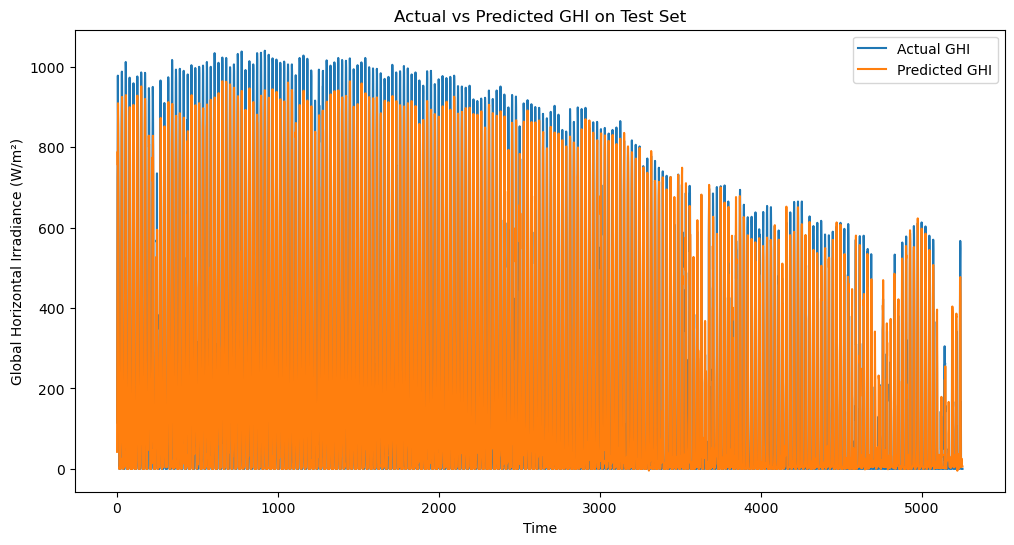

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
# Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set
# Ensure the model is in evaluation mode
net.eval()

# Make predictions on the test set
with torch.no_grad():
    test_predictions, _, _ = net(test_X.to(device))
    test_predictions = test_predictions.cpu().numpy()

# Inverse transform the predictions and actual values using target_scaler
test_predictions_inv = target_scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_y_inv = target_scaler.inverse_transform(test_y.numpy().reshape(-1, 1))

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(test_y_inv, test_predictions_inv))
test_mae = mean_absolute_error(test_y_inv, test_predictions_inv)

print(f"Test RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12,6))
plt.plot(test_y_inv, label='Actual GHI')
plt.plot(test_predictions_inv, label='Predicted GHI')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual vs Predicted GHI on Test Set')
plt.legend()
plt.show()


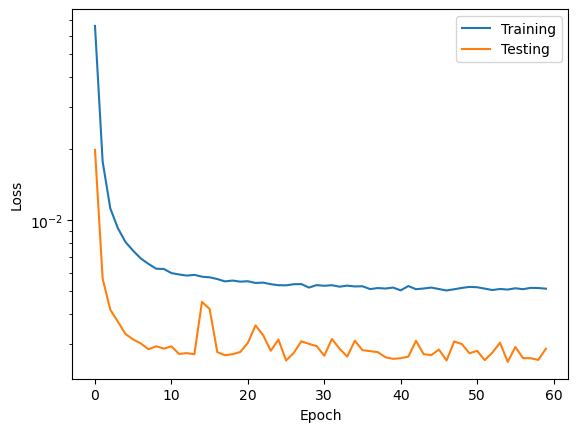

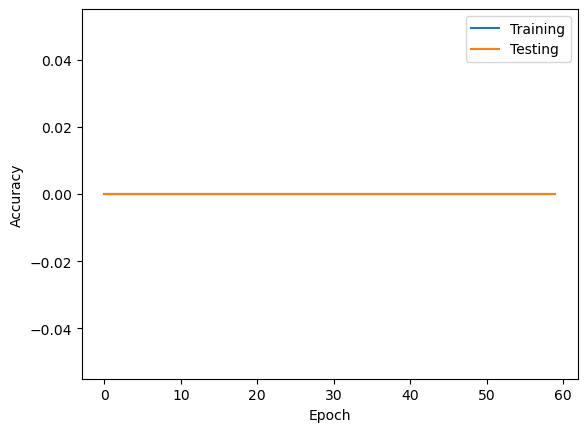

In [13]:
stats.plot()


In [14]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 1640


# SNN-CNN-Multivariate-Sigma-Delta-Network-SDNN-LAVA

In [15]:
from lava.lib.dl.slayer.neuron import Dropout
from pandas import read_csv
#dataset = read_csv('jordan_pv.csv', parse_dates=['date'], infer_datetime_format=True, index_col='date')
dataset = read_csv('Palestine-PV.csv', parse_dates=['date'],  index_col='date')
# Convert index to datetime
dataset.index = pd.to_datetime(dataset.index)
# Sort the DataFrame by the index (date) in ascending order to ensure oldest to newest
dataset = dataset.sort_index()
# summarize first 5 rows
#print(dataset.head(5))
dataset = dataset[~np.isnan(dataset)]
# Drop rows with missing values
dataset= dataset.dropna()
#dataset.info() 
dataset = dataset.astype(np.float64)
#dataset.shape
def series_to_supervised(data, target_col_name, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # Ensure the target column is the last column in the dataframe
    df = df[[col for col in df if col != target_col_name] + [target_col_name]]
    # Input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # Forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars-1)]  # Exclude the target variable
            names.append(target_col_name + '(t)')  # Add the target variable with the current timestep
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # Put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # Remove the forecasted sequence for other variables, keep only for the target variable
    agg = agg[[col for col in agg if target_col_name in col or '(t)' not in col]]

    # Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg
# load dataset

values = dataset.values

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
df_scaled = pd.DataFrame(scaled, columns=dataset.columns)
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaled = target_scaler.fit_transform(dataset[['Solar Radiation(GHI)']])
# frame as supervised learnin
reframed = series_to_supervised(df_scaled, 'Solar Radiation(GHI)',3, 1)
#print(reframed.head())
# Spilt into Train  and Test Set
values = reframed.values
n_train_hours = 876 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#print(train_X) ,print(train_y)
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

      
# Convert data and labels to PyTorch tensors
train_X=torch.Tensor(train_X)
train_y = torch.Tensor(train_y)
test_X=torch.Tensor(test_X)
test_y = torch.Tensor(test_y)

# Hyperparameters
spike_rate = 0.1
temporal_rate = 1
def event_rate_loss(x, max_rate=0.01):
    mean_event_rate = torch.mean(torch.abs(x))
    return F.mse_loss(F.relu(mean_event_rate - max_rate), torch.zeros_like(mean_event_rate))
class Network(torch.nn.Module):
    def __init__(self):
        super(Network, self).__init__()
         # Flag to track sparsity printing
        self.printed_sparsity = False
        sdnn_params = { # sigma-delta neuron parameters
                'threshold'     : 0.05 ,  # delta unit threshold
                'tau_grad'      : 0.05,    # delta unit surrogate gradient relaxation parameter
                'scale_grad'    : 1,      # delta unit surrogate gradient scale parameter
                'requires_grad' : True,   # trainable threshold
                'shared_param'  : True,   # layer wise threshold
                'activation'    : F.relu, # activation function
            }
        sdnn_cnn_params = { # conv layer has additional mean only batch norm
                **sdnn_params,                                 # copy all sdnn_params
                'norm' : slayer.neuron.norm.MeanOnlyBatchNorm, # mean only quantized batch normalizaton
            }
        sdnn_dense_params = { # dense layers have additional dropout units enabled
                **sdnn_cnn_params,                        # copy all sdnn_cnn_params
                'dropout' : slayer.neuron.Dropout(p=0.05), # neuron dropout
            }
           
        self.blocks = torch.nn.ModuleList([
            #torch.nn.Conv3d(in_channels=3, out_channels=32, kernel_size=1),
           # delta encoding of the input
            slayer.block.sigma_delta.Input(sdnn_cnn_params),
            # convolution layers
            slayer.block.sigma_delta.Conv(sdnn_cnn_params,18 ,32, kernel_size=1),# weight_scale=2, weight_norm=True),
            slayer.block.sigma_delta.Conv(sdnn_cnn_params,32, 32, kernel_size=1),# weight_scale=2, weight_norm=True),
            
          # flatten layer
            slayer.block.sigma_delta.Flatten(),
            
            # dense layers
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32,32, weight_scale=2),# weight_norm=True),
            slayer.block.sigma_delta.Dense(sdnn_dense_params, 32,32, weight_scale=2),# weight_norm=True),
            # linear readout with sigma decoding of output
            slayer.block.sigma_delta.Output(sdnn_dense_params,32, 1),# weight_scale=2, weight_norm=True)
        ])
        self.sparsity_tracker = {i: [] for i in range(len(self.blocks))}
    def forward(self, x):
        count = []
        event_cost = 0
        sparsity_list = []  # Initialize the sparsity list here

        for i, block in enumerate(self.blocks):
            # forward computation is as simple as calling the blocks in a loop
            x = block(x)
            #print("Input shape:", x.shape)
            if hasattr(block, 'neuron'):
                event_cost += event_rate_loss(x)
                # Masked tensor where elements of x that are greater than 0 are preserved,
                # and others are set to 0
                #masked_x = torch.where(x[..., 1:] > 0, x[..., 1:], torch.zeros_like(x[..., 1:]))
                masked_x = torch.where(x > 0, x, torch.zeros_like(x))

                # Compute the sum of absolute values of this new tensor
                count.append(torch.sum(torch.abs(masked_x)).item())
                #count.append(torch.sum(torch.sum((x[..., 1:]) > 0).to(x.dtype)).item())
                # Before computing sparsity, check if total_elements is greater than zero
               
        return x, event_cost, torch.FloatTensor(count).reshape((1, -1)).to(x.device)

    def grad_flow(self, path):
        # helps monitor the gradient flow
        grad = [b.synapse.grad_norm for b in self.blocks if hasattr(b, 'synapse')]

        plt.figure()
        plt.semilogy(grad)
        plt.savefig(path + 'gradFlow.png')
        plt.close()
        return grad
    def export_hdf5(self, filename):
        # network export to hdf5 format
        h = h5py.File(filename, 'w')
        layer = h.create_group('layer')
        for i, b in enumerate(self.blocks):
            b.export_hdf5(layer.create_group(f'{i}'))

train_X = train_X.reshape((train_X.shape[0],train_X.shape[1], 1,1,1))
test_X = test_X.reshape((test_X.shape[0],test_X.shape[1], 1,1 ,1))
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)
batch  =64# batch size
lr     = 0.001# leaerning rate
lam    = 0.01  # lagrangian for event rate loss
epochs =60  # training epochs
steps  = [60, 120, 160] # learning rate reduction milestones
trained_folder = 'Trained'
logs_folder = 'Logs'
os.makedirs(trained_folder, exist_ok=True)
os.makedirs(logs_folder   , exist_ok=True)
#device = torch.device('cuda')
device = torch.device('cpu')
# Instantiate Network, Optimizer, Dataset, and Dataloader
net = Network().to(device)
optimizer = torch.optim.RAdam(net.parameters(), lr=lr, weight_decay=1e-5) #CONV and Dense
#optimizer = torch.optim.SGD(net.parameters(), lr=lr, weight_decay=1e-5) #CONV and Dense
#optimizer = torch.optim.Adam(net.parameters(), lr=0.001)     #For cuba
training_set = torch.utils.data.TensorDataset(train_X, train_y)
testing_set = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = torch.utils.data.DataLoader(dataset=training_set, batch_size=batch, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=testing_set, batch_size=batch, shuffle=False)
stats = slayer.utils.LearningStats()
assistant = slayer.utils.Assistant(
    net=net,
    error=lambda output  , target: F.mse_loss(output.flatten(), target.flatten()),
    optimizer=optimizer,
    stats=stats,
    count_log=True,
    lam=lam,
    #classifier=slayer.classifier.Rate.predict
)
for epoch in range(epochs):
    #if epoch in steps:
        #for param_group in optimizer.param_groups:    
           # print('\nLearning rate reduction from', param_group['lr'])
            #param_group['lr'] /= 10/3
        
    for i, (input, ground_truth) in enumerate(train_loader): # training loop
        
        assistant.train(input, ground_truth)
        print(f'\r[Epoch {epoch:3d}/{epochs}] {stats}', end='')
    
    for i, (input, ground_truth) in enumerate(test_loader): # testing loop
        
        assistant.test(input, ground_truth)
        print(f'\r[Epoch {epoch:3d}/{epochs}] {stats}', end='')
        
    if epoch%50==49: print() 
    if stats.testing.min_loss:  
        torch.save(net.state_dict(), trained_folder + '/network.pt')
    stats.update()
    stats.save(trained_folder + '/')
    
    # checkpoint saves
    if epoch%10 == 0:
        torch.save({'net': net.state_dict(), 'optimizer': optimizer.state_dict()}, logs_folder + f'/checkpoint{epoch}.pt')         
     

(21024, 18) (21024,) (5253, 18) (5253,)
torch.Size([21024, 18, 1, 1, 1])
torch.Size([5253, 18, 1, 1, 1])
torch.Size([21024])
torch.Size([5253])
[Epoch  49/60] Train loss =     0.00453 (min =     0.00453)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.00233 (min =     0.00236)     accuracy = 0.00000 (max = 0.00000) 
[Epoch  59/60] Train loss =     0.00465 (min =     0.00450)     accuracy = 0.00000 (max = 0.00000)  | Test  loss =     0.00247 (min =     0.00233)     accuracy = 0.00000 (max = 0.00000) 

#  Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set

Test RMSE (Unnormalized): 52.3131
Test MAE (Unnormalized): 25.1488


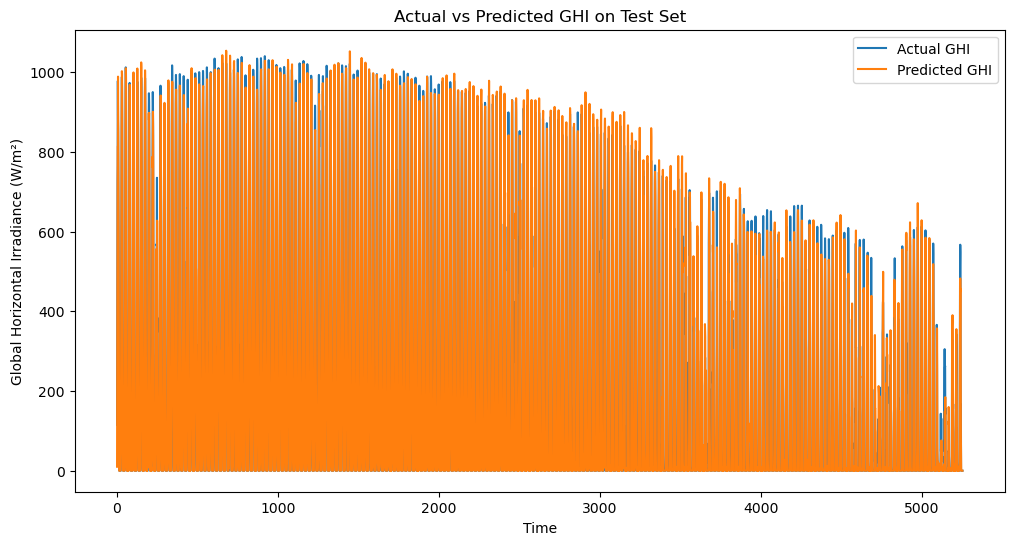

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
# Evaluation: Calculate and Print Unnormalized RMSE and MAE for Testing Set
# Ensure the model is in evaluation mode
net.eval()

# Make predictions on the test set
with torch.no_grad():
    test_predictions, _, _ = net(test_X.to(device))
    test_predictions = test_predictions.cpu().numpy()

# Inverse transform the predictions and actual values using target_scaler
test_predictions_inv = target_scaler.inverse_transform(test_predictions.reshape(-1, 1))
test_y_inv = target_scaler.inverse_transform(test_y.numpy().reshape(-1, 1))

# Calculate RMSE and MAE
test_rmse = np.sqrt(mean_squared_error(test_y_inv, test_predictions_inv))
test_mae = mean_absolute_error(test_y_inv, test_predictions_inv)

print(f"Test RMSE (Unnormalized): {test_rmse:.4f}")
print(f"Test MAE (Unnormalized): {test_mae:.4f}")

# Optionally, plot the predictions vs actual values
plt.figure(figsize=(12,6))
plt.plot(test_y_inv, label='Actual GHI')
plt.plot(test_predictions_inv, label='Predicted GHI')
plt.xlabel('Time')
plt.ylabel('Global Horizontal Irradiance (W/m²)')
plt.title('Actual vs Predicted GHI on Test Set')
plt.legend()
plt.show()


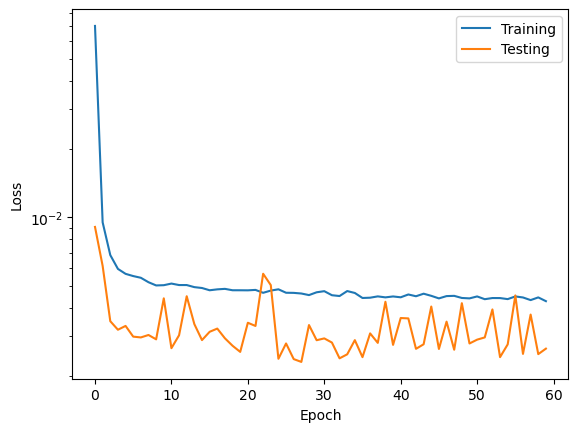

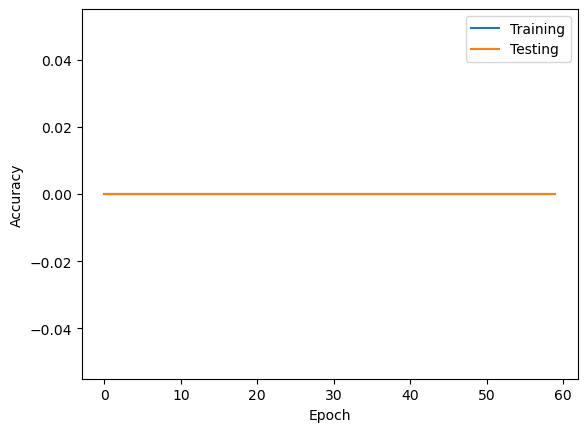

In [35]:
stats.plot()


In [8]:
# Calculate the total number of trainable parameters
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f"Total number of trainable parameters: {total_params}")

Total number of trainable parameters: 3692


# Event statistics on testing dataset


In [20]:
counts = []
for i, (input, ground_truth) in enumerate(test_loader):
    _, count = assistant.test(input, ground_truth)
    count = (count.flatten() / input.shape[0]).tolist()  # normalize by batch size
    counts.append(count)
    print('\rEvent count : ' + ', '.join([f'{c:.4f}' for c in count]), f'| {stats.testing}', end='')

counts = np.mean(counts, axis=0)


Event count : 15.9688, 2.3911, 0.9802, 0.8862, 0.3549, 0.0612 | loss =     0.00322 (min =     0.00224)     accuracy = 0.00000 (max = 0.00000) 

In [23]:
import importlib.util

spec = importlib.util.spec_from_file_location("desired_utils", "D:/Profiles/anaconda/Lib/site-packages/lava-dl/tutorials/lava/lib/dl/slayer/pilotnet/utils.py")
#spec = importlib.util.spec_from_file_location("desired_utils", "C:/Users/bahgat.ayasi/AppData/Local/anaconda3/Lib/site-packages/lava-dl/tutorials/lava/lib/dl/slayer/pilotnet/utils.py")

desired_utils = importlib.util.module_from_spec(spec)
spec.loader.exec_module(desired_utils)


# Now you can use desired_utils as the module
#desired_utils.compare_ops()


In [24]:

print(desired_utils.__file__)


D:/Profiles/anaconda/Lib/site-packages/lava-dl/tutorials/lava/lib/dl/slayer/pilotnet/utils.py


In [25]:
#utils.compare_ops(net, counts, mse=stats.testing.min_loss)
desired_utils.compare_ops(net, counts, mse=stats.testing.min_loss)


|-----------------------------------------------------------------------------|
|                         |          SDNN           |           ANN           |
|-----------------------------------------------------------------------------|
|         |     Shape     |  Events  |    Synops    | Activations|    MACs    |
|-----------------------------------------------------------------------------|
| layer-0 | (  1,  1, 36) |    18.05 |              |         36 |            |
| layer-1 | (  1,  1, 32) |     2.67 |       577.50 |         32 |       1152 |
| layer-2 | (  1,  1, 32) |     1.58 |        85.30 |         32 |       1024 |
| layer-3 | (  1,  1, 32) |     1.82 |        50.40 |         32 |       1024 |
| layer-4 | (  1,  1, 32) |     1.58 |        58.11 |         32 |       1024 |
| layer-5 | (  1,  1,  1) |     0.24 |         1.58 |          1 |         32 |
|-----------------------------------------------------------------------------|
|  Total  |               |    25.93 |  

In [46]:
total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print(f'Total number of parameters: {total_params}')

Total number of parameters: 1640


# plot the Archtecue 

In [133]:
from graphviz import Digraph

dot = Digraph(comment='The MLP Architecture')

# Define the nodes
dot.node('A', 'Input')
dot.node('B', 'Dense 3->32')
dot.node('C', 'Dense 32->32')
dot.node('D', 'Output 32->1')

# Connect the nodes
dot.edges(['AB', 'BC', 'CD'])

# Save and render the graph as a high-resolution JPEG image
dot.render('MLP_architecture', format='jpeg', cleanup=True)

# Since Graphviz does not directly support DPI settings for JPEG,
# we use PIL to open the JPEG and save it with the desired DPI.
from PIL import Image

# Open the original JPEG
img = Image.open('MLP_architecture.jpeg')

# Specify the DPI
dpi_value = 1000
img.save('MLP_architecture_high_res.jpeg', dpi=(dpi_value, dpi_value))


In [134]:
# Assuming the graphviz output 'MLP_architecture.jpeg' exists

from PIL import Image

# Open the graphviz-generated JPEG
original_img = Image.open('MLP_architecture.jpeg')

# Create a new image with the desired dimensions and DPI
dpi_value = 1000
width_cm, height_cm = 9, 13.78
width_inch, height_inch = width_cm / 2.54, height_cm / 2.54
new_width, new_height = int(width_inch * dpi_value), int(height_inch * dpi_value)

# Create a blank image with the desired size and white background
new_img = Image.new('RGB', (new_width, new_height), 'white')

# Calculate position to paste the original image centered in the new image
x = (new_width - original_img.width) // 2
y = (new_height - original_img.height) // 2

# Paste the original image onto the blank image
new_img.paste(original_img, (x, y))

# Save the new image
new_img.save('MLP_architecture_resized.jpeg', 'JPEG', dpi=(dpi_value, dpi_value))


In [142]:
from graphviz import Digraph
from PIL import Image

# Create the MLP architecture diagram
dot = Digraph(comment='The MLP Architecture')
dot.node('A', 'Input')
dot.node('B', 'Dense 3->32')
dot.node('C', 'Dense 32->32')
dot.node('D', 'Output 32->1')
dot.edges(['AB', 'BC', 'CD'])

# Render the graph to a file (before resizing)
dot.render('MLP_architecture', format='png', cleanup=True)

# Open the rendered image
img = Image.open('MLP_architecture.png')

# Convert the image to RGB mode
img_rgb = img.convert('RGB')

# Desired physical dimensions in cm converted to inches (1 inch = 2.54 cm)
width_cm, height_cm = 6.5, 16
width_in, height_in = width_cm / 2.54, height_cm / 2.54

# Desired DPI
dpi_value = 1500

# Calculate desired size in pixels
width_px, height_px = int(width_in * dpi_value), int(height_in * dpi_value)

# Resize image to desired dimensions using the LANCZOS filter
img_resized = img_rgb.resize((width_px, height_px), Image.Resampling.LANCZOS)

# Save the resized image in JPEG format
img_resized.save('MLP_architecture_resized.jpeg', 'JPEG', dpi=(dpi_value, dpi_value))
